# Тетрадка содержит:
    подготовку корпуса текстов и обучение Word2Vec на этом корпусе
    расчет эмбеддингов с помощью полученной модели
    определение ключевых слов для каждой статьи
    исследование получившихся эмбеддингов - кластеризацию и облако слов

Для обучения модели Word2Vec заново нужно выставить флаг retrain_model в True (см "Обучаем word2vec на полученном корпусе")

Внимание: обучение word2vec заново не будет в точности повторять предыдущее обучение, так как проводится в многопоточном режиме. Новая модель word2vec модет привести к необходимости повторного отбора признаков и тюнинга моделей прогноза популярности.

Пункты с кластеризацией и облаком слов не являются частью пайплайна обучения и прогноза. Это исследовательская часть.

Иногда при перерасчете происходит падение pymystem3 (было пару раз) с выдачей в тексте ошибки бинаризованного куска текста. Это не является проблемой в коде и лечится повторным запуском ячейки

Внимание: на ОС Windows лемматизатор pymystem3 может работать аномально долго, это известный баг. На MacOS тетрадка отрабатывает целиком примерно за 10 минут

In [19]:
%load_ext autoreload
import os
import pandas as pd
import html
import json

from pymystem3 import Mystem
import nltk
from nltk.corpus import LazyCorpusLoader, WordListCorpusReader

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from IPython.display import display

from rbk.utils.global_vars import \
    RANDOM_STATE, ROOT_ABSPATH, PREPARED_DATA_PATH, MODELS_PATH, EMBEDDINGS_PATH

from rbk.utils import my_plotlib, text_processing, embeddings

# загрузка стопслов nltk
nltk_path = os.path.join(ROOT_ABSPATH, MODELS_PATH, 'nltk')

if not os.path.isdir(nltk_path):
    nltk.download("stopwords", nltk_path)

russian_stopwords = LazyCorpusLoader("stopwords",
                                    WordListCorpusReader,
                                    r"(?!README|\.).*",
                                    encoding="utf8",
                                    nltk_data_subdir=os.path.join(nltk_path, 'corpora')).words("russian")

pd.set_option('display.max_columns', None)
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_train = pd.read_parquet(os.path.join(ROOT_ABSPATH, PREPARED_DATA_PATH, 'train.parquet'))
df_test = pd.read_parquet(os.path.join(ROOT_ABSPATH, PREPARED_DATA_PATH, 'test.parquet'))
df_all = pd.concat([df_train, df_test])

# Сделаем классические эмбеддинги слов на word2vec

## Предобработка: объединим заголовок, описание и текст статьи, выполним очистку текста и лемматизацию

In [3]:
lemmatizer = Mystem()

raw_corpus = df_all['title'] + ' . '\
            + df_all['description_parsed'] + ' . '\
                + df_all['article_text_parsed']

with pd.option_context('display.max_colwidth', 300):
    display(raw_corpus.head(2))

document_id
55c3984d9a79470f2c260465BKmAn_fHQruT38beqDIE_A    Развод на миллионы: как российские бизнесмены расходились с женами . 19 мая стало известно, что Алишер Усманов подал на развод с Ириной Винер. Супруги прожили в браке 30 лет. Судебное заседание назначено на 7 июня.&nbsp;\n\nРоссийские бизнесмены известны своими дорогими и долгими бракоразводными...
5a8eb3149a7947e3e34bba2dbgzlzJ2GTQacZgtv4WEb1A    МОК дал, МОК взял: как атлеты лишались олимпийских медалей из-за допинга . МОК отказался от церемонии&nbsp;награждения в командном турнире по фигурному катанию, где российские спортсменки завоевали золото&nbsp;&mdash; из-за положительной допинг-пробы Камиллы Валиевой, сданной до Игр. 14 февраля ...
dtype: object

In [4]:
corpus = raw_corpus.apply(html.unescape)
corpus = corpus.str.replace('МОК', 'международный олимпийский комитет')
corpus = corpus.apply(text_processing.clean_all_symbols)

with pd.option_context('display.max_colwidth', 300):
    display(corpus.head(2))

document_id
55c3984d9a79470f2c260465BKmAn_fHQruT38beqDIE_A    развод на миллионы как российские бизнесмены расходились с женами мая стало известно что алишер усманов подал на развод с ириной винер супруги прожили в браке лет судебное заседание назначено на июня российские бизнесмены известны своими дорогими и долгими бракоразводными процессами в судах на р...
5a8eb3149a7947e3e34bba2dbgzlzJ2GTQacZgtv4WEb1A    международный олимпийский комитет дал международный олимпийский комитет взял как атлеты лишались олимпийских медалей из за допинга международный олимпийский комитет отказался от церемонии награждения в командном турнире по фигурному катанию где российские спортсменки завоевали золото из за полож...
dtype: object

In [5]:
corpus = corpus.progress_apply(text_processing.lemmatize_text, lemmatizer=lemmatizer, stop_words=russian_stopwords)

100%|██████████| 10000/10000 [03:59<00:00, 41.71it/s]


In [6]:
splited_corpus = corpus.str.split()

In [7]:
with pd.option_context('display.max_colwidth', 300):
    display(splited_corpus.head(2))

document_id
55c3984d9a79470f2c260465BKmAn_fHQruT38beqDIE_A    [развод, миллион, российский, бизнесмен, расходиться, жена, май, становиться, известный, алишер, усманов, подавать, развод, ирина, винер, супруг, проживать, брак, год, судебный, заседание, назначать, июнь, российский, бизнесмен, известный, свой, дорогой, долгий, бракоразводный, процесс, суд, род...
5a8eb3149a7947e3e34bba2dbgzlzJ2GTQacZgtv4WEb1A    [международный, олимпийский, комитет, давать, международный, олимпийский, комитет, взять, атлет, лишаться, олимпийский, медаль, допинг, международный, олимпийский, комитет, отказываться, церемония, награждение, командный, турнир, фигурный, катание, российский, спортсменка, завоевывать, золото, п...
dtype: object

## Обучаем word2vec на полученном корпусе

Для обучения модели Word2Vec заново нужно выставить флаг retrain_model выставить в True

Внимание: обучение word2vec заново не будет в точности повторять предыдущее обучение, так как проводится в многопоточном режиме. Новая модель word2vec модет привести к необходимости повторного отбора признаков и тюнинга моделей прогноза популярности.

In [8]:
%autoreload 2
full_pars = dict(
    min_count=5,
    window=9,
    vector_size=100,
    negative=5,
    epochs=20)
# Для того, чтобы обучить модель заново, нужно параметр retrain_model выставить в True
w2v_full = embeddings.GetTrainModel(model_name='w2v_full', model_pars=full_pars, retrain_model=False)

w2v_full.get_train_model(corpus=splited_corpus)

INFO - 02:36:13: loading Word2Vec object from /Users/affernus/PROJECTS/hacks/RBC/src/models/word2vec/w2v_full.model
INFO - 02:36:13: loading wv recursively from /Users/affernus/PROJECTS/hacks/RBC/src/models/word2vec/w2v_full.model.wv.* with mmap=None
INFO - 02:36:13: setting ignored attribute cum_table to None
INFO - 02:36:14: Word2Vec lifecycle event {'fname': '/Users/affernus/PROJECTS/hacks/RBC/src/models/word2vec/w2v_full.model', 'datetime': '2022-07-19T02:36:14.003417', 'gensim': '4.2.0', 'python': '3.9.4 (default, Oct 26 2021, 00:39:45) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-12.0.1-x86_64-i386-64bit', 'event': 'loaded'}


## Получаем эмбеддинги для статей, заголовков, авторов и т.д.

Принцип: эмбеддинг статьи (заголовка) строится как взвешенное на idf среднее векторов слов, входящих в статью. Дополнительно также считаем эмбеддинг первых 100 слов статьи и последних 100 слов

Эмбеддинги авторов и тегов строятся как средние эмбеддинги статей, в которых встречался данный тег/автор

In [9]:
idf, _ = text_processing.get_idf(corpus)

In [10]:
titles_prepared = df_all['title']
titles_prepared = titles_prepared.apply(html.unescape)
titles_prepared = titles_prepared.str.replace('МОК', 'международный олимпийский комитет')
titles_prepared = titles_prepared.apply(text_processing.clean_all_symbols)

titles_prepared = titles_prepared.progress_apply(
    text_processing.lemmatize_text, lemmatizer=lemmatizer, stop_words=russian_stopwords
    )
titles_prepared = titles_prepared.str.split()
titles_embs = titles_prepared.progress_apply(embeddings.calc_summary_embedding, args=(w2v_full.model.wv,), idf=idf)

 19%|█▉        | 1889/10000 [00:00<00:00, 8851.33it/s]

ялунина отсутствует в idf
протетстос отсутствует в idf


 48%|████▊     | 4767/10000 [00:00<00:00, 9496.30it/s]

фейгина отсутствует в idf
доорогой отсутствует в idf


 67%|██████▋   | 6654/10000 [00:00<00:00, 9314.01it/s]

костюкова отсутствует в idf
стокманна отсутствует в idf


 86%|████████▋ | 8640/10000 [00:00<00:00, 9631.22it/s]

калиматова отсутствует в idf
буянова отсутствует в idf
силуанова отсутствует в idf


100%|██████████| 10000/10000 [00:01<00:00, 9389.23it/s]


In [11]:
txt = titles_prepared[5]
tmp_emb = embeddings.calc_summary_embedding(txt, w2v_full.model.wv, idf=idf)
display(w2v_full.model.wv.most_similar(tmp_emb))
print(txt)

[('праздник', 0.859032928943634),
 ('отдыхать', 0.7476552128791809),
 ('майский', 0.6997392773628235),
 ('календарь', 0.6110228896141052),
 ('выходной', 0.5753605961799622),
 ('празднование', 0.5173995494842529),
 ('влюбленный', 0.509384036064148),
 ('байрам', 0.5044017434120178),
 ('россиянин', 0.5043654441833496),
 ('праздничный', 0.49917924404144287)]

['россиянин', 'отдыхать', 'год', 'календарь', 'праздник']


In [12]:
full_embs = splited_corpus.progress_apply(embeddings.calc_summary_embedding, args=(w2v_full.model.wv,), idf=idf)

100%|██████████| 10000/10000 [00:19<00:00, 513.46it/s]


In [13]:
first_part_embs = splited_corpus.apply(lambda x: x[:100]).progress_apply(embeddings.calc_summary_embedding, args=(w2v_full.model.wv,), idf=idf)

100%|██████████| 10000/10000 [00:07<00:00, 1250.10it/s]


In [14]:
last_part_embs = splited_corpus.apply(lambda x: x[-100:]).progress_apply(embeddings.calc_summary_embedding, args=(w2v_full.model.wv,), idf=idf)

100%|██████████| 10000/10000 [00:07<00:00, 1322.87it/s]


In [15]:
tag_embs_map = embeddings.encode_category_by_embs(full_embs, df_all, 'tags')

In [16]:
authors_embs_map = embeddings.encode_category_by_embs(full_embs, df_all, 'authors')

### Сохраняем полученные эмбеддинги

In [17]:
tags_embs = df_all['tags'].explode().map(tag_embs_map).groupby(level=0).mean()
authors_embs = df_all['authors'].explode().map(authors_embs_map).groupby(level=0).mean()

In [20]:
full_embs_df = embeddings.get_embs_df(full_embs, 'full')
tags_embs_df = embeddings.get_embs_df(tags_embs, 'tag')
titles_embs_df = embeddings.get_embs_df(titles_embs, 'title')
authors_embs_df = embeddings.get_embs_df(authors_embs, 'author')

first_part_embs_df = embeddings.get_embs_df(first_part_embs, 'first')
last_part_embs_df = embeddings.get_embs_df(last_part_embs, 'last')

embs_path = os.path.join(ROOT_ABSPATH, EMBEDDINGS_PATH)

full_embs_df.to_parquet(os.path.join(embs_path, 'full_embs.parquet'))
titles_embs_df.to_parquet(os.path.join(embs_path, 'titles_emb.parquet'))

tags_embs_df.to_parquet(os.path.join(embs_path, 'tags_embs.parquet'))
authors_embs_df.to_parquet(os.path.join(embs_path, 'authors_embs.parquet'))
first_part_embs_df.to_parquet(os.path.join(embs_path, 'first_part_embs.parquet'))
last_part_embs_df.to_parquet(os.path.join(embs_path, 'last_part_embs.parquet'))

Выделим для каждой статьи ключевые слова (топ 3) и сохраним

In [21]:
top_n = 3
topn_similar = full_embs_df.apply(
    lambda x: [w[0] for w in w2v_full.model.wv.most_similar(x.values)][:top_n], 
    axis=1)
topn_similar = topn_similar.apply(pd.Series)
topn_similar.columns = [f'top{i+1}_similar' for i in range(top_n)]
display(topn_similar.head())

topn_similar.to_parquet(os.path.join(embs_path, 'topn_similar.parquet'))

,top1_similar,top2_similar,top3_similar
document_id,,,
55c3984d9a79470f2c260465BKmAn_fHQruT38beqDIE_A,супруга,развод,разводиться
5a8eb3149a7947e3e34bba2dbgzlzJ2GTQacZgtv4WEb1A,завоевывать,медаль,катание
605321259a7947663a3b6ab2vgBnAMPBRIOYrUrK0JeEiQ,гагарин,космонавт,кастро
609d47119a794795c5f7617dh5z7vG_TQAu5Q7Nwp35LUw,медведчук,опзж,порошенко
5afd8e7f9a794772862de199oXkM3UjQQRK7NZTlmVi63A,хищение,ишаев,взятка


# Исследуем полученные эмбеддинги: как делятся на кластеры, какие слова являются определяющими

## Определяем оптимальное число кластеров

Для пересчета temp_clusterer.inertia_ можно удалить файл full_distortion.json из src/models/clusterer/

Перерасчет займет около полутора - двух минут. Для ускорения можно уменьшить clusters_range (не range(1, 50), а, например, range(1, 20))

In [22]:
distortion = []
clusters_range = range(1, 50)
for n_clusters in tqdm(clusters_range):
    temp_clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    temp_clusterer.fit(full_embs.apply(pd.Series))
    distortion.append(temp_clusterer.inertia_)

100%|██████████| 49/49 [01:31<00:00,  1.86s/it]


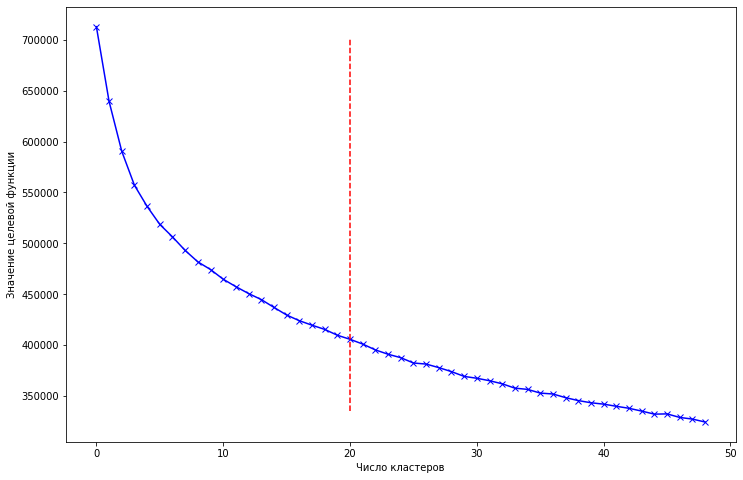

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(distortion, 'bx-')
ylim = ax.get_ylim()
n_clusters = 20
ax.vlines(n_clusters, ylim[0]+.1*ylim[0], ylim[1]-.1*ylim[0], colors='r', linestyles='--')
ax.set_xlabel('Число кластеров')
ax.set_ylabel('Значение целевой функции')
plt.show() 

## Учим KMeans на выбранное количество кластеров, снижаем размерность (TSNE), строим scatterplot

/Users/affernus/.pyenv/versions/3.9.4/envs/rbc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/affernus/.pyenv/versions/3.9.4/envs/rbc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


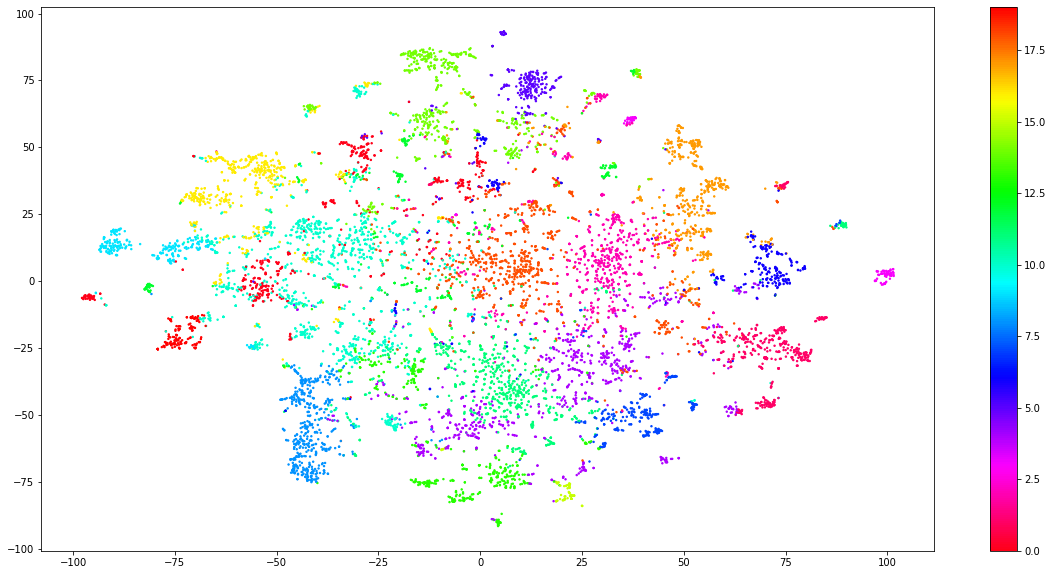

In [24]:
# учим кластеризатор на выбранное количество кластеров
articles_clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
articles_clusterer.fit(full_embs.apply(pd.Series))
# Подготовка данных
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
emds_for_plot = tsne.fit_transform(full_embs.apply(pd.Series))
clusters_dash = pd.DataFrame(emds_for_plot, columns=['x', 'y'])
clusters_dash['labels'] = articles_clusterer.labels_

# Визуализация кластеров
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(clusters_dash['x'], clusters_dash['y'], c=clusters_dash['labels'], s=2, cmap='hsv_r')
plt.colorbar()
plt.show()

## Строим облака слов для кластеров, оцениваем полученное разделение

Перерасчет займет порядка 3 минут

In [25]:
df_all['article_cluster'] = articles_clusterer.labels_

text cleaning started
text cleaning done
lemmatization started


100%|██████████| 10000/10000 [03:22<00:00, 49.47it/s]


lemmatization done
tf-idf started
all done!


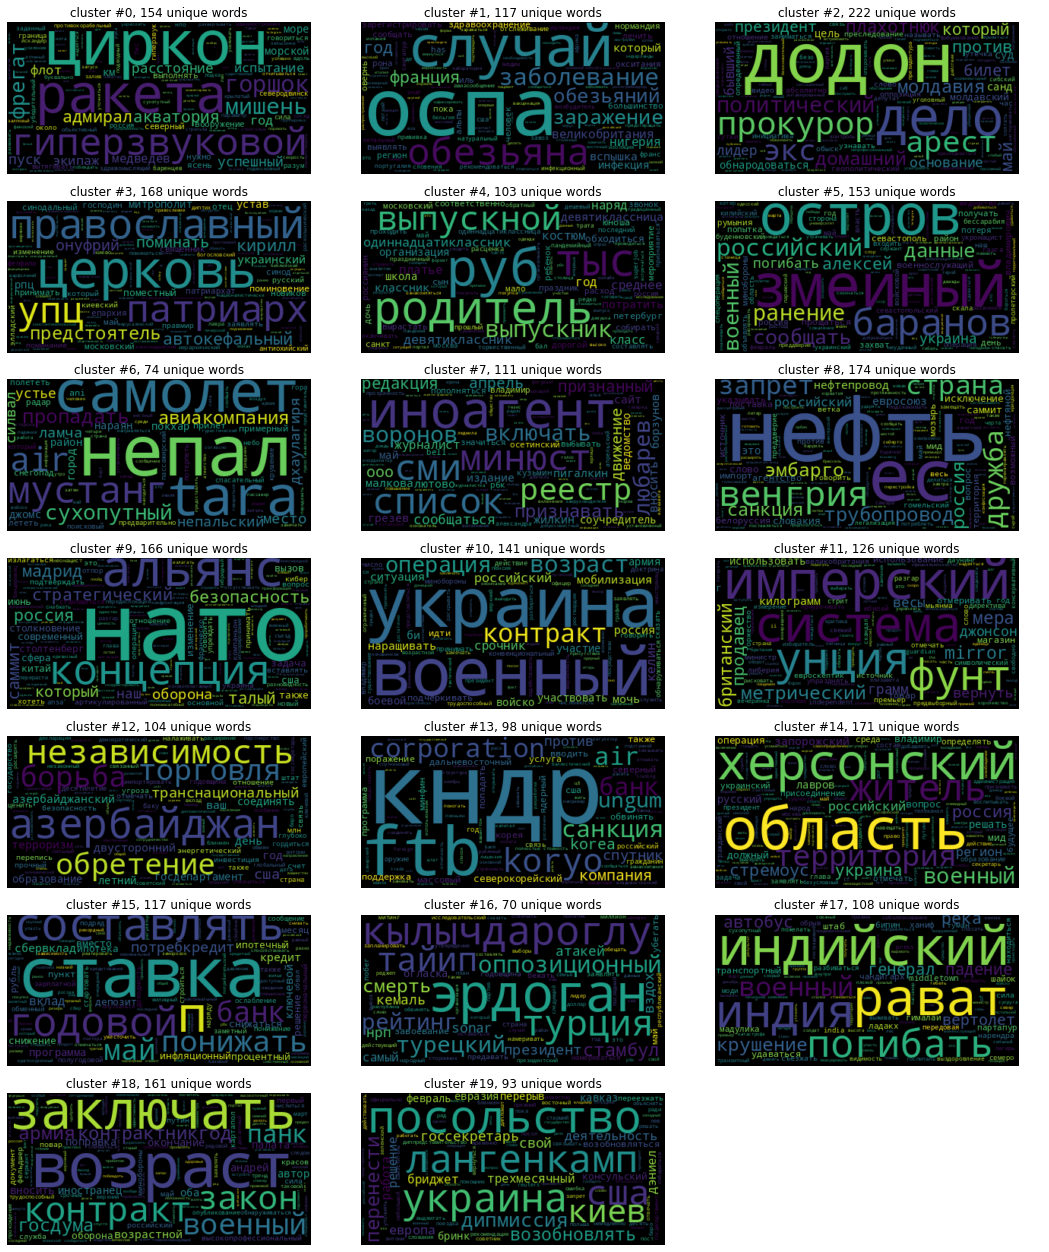

In [26]:
lemmatizer = Mystem()
clusters_tf = text_processing.get_tf_idf_for_clusters(df_all['article_text_parsed'],
                                               df_all['article_cluster'],
                                               lemmatizer=lemmatizer,
                                               stop_words=russian_stopwords,
                                               use_idf=True)

my_plotlib.plot_word_cloud(clusters_tf)